# Image Captioning with RNNs

In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

## 1. Basic settings

In [1]:
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CS231n.RNN_layers import *
from CS231n.classifiers.rnn import CaptioningRNN
from CS231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from CS231n.image_utils import image_from_url
from CS231n.Captioning_solver import CaptioningSolver

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 2. Microsoft COCO

For this exercise we will use the 2014 release of the Microsoft COCO dataset which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images.

- *train2014_vgg16_fc7.h5 and val2014_vgg16_fc7.h5*: features extracted from the fc7 layer of the VGG-16 network pretrained on ImageNet.
- *train2014_vgg16_fc7_pca.h5 and val2014_vgg16_fc7_pca.h5*:  reduced the dimensionality of the features from 4096 to 512 using PCA.
- *train2014_urls.txt and val2014_urls.txt*: URLs of the training and validation images.
- *coco2014_vocab.json*: Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in this file. you can use the function **decode_captions** from the file CS231n/coco_utils.py to convert numpy arrays of integer IDs back into strings.

**Note**

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


In [3]:
# Sample a minibatch and show the images and captions
if 0:
    batch_size = 3

    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()

## 3. Recurrent Neural Networks

## 3.1 Vanilla RNN: step forward

Run the forward pass for a single timestep of a vanilla RNN that uses a tanh activation function. 

The input data has dimension D, the hidden state has dimension H, and we use a minibatch size of N:
```python
affine_output = prev_h.dot(Wh) + x.dot(Wx) + b    # of shape (N, H)
next_h = np.tanh(affine_output)
```

In [4]:
N, D, H = 3, 10, 4
x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = RNN_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
[-0.58172089, -0.50182032, -0.41232771, -0.31410098],
[ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
[ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.29242142647e-09


## 3.2 Vanilla RNN: step backward

Just like the affine forward, backward pass for a single timestep of a vanilla RNN is performed.

First, we get the derivative of a tanh() function:
$$
  f(x) = tanh(x) = (e^x - e^{-x}) / (e^x + e^{-x}) \\
   df(x) / d(x) = 1 - f^2(x)
$$
```python
daffine_output = dnext_h * (1 - next_h * next_h)

dx = daffine_output.dot(Wx.T)
dWx = x.T.dot(daffine_output)

dprev_h = daffine_output.dot(Wh.T)   # pay attenion to this transpose
dWh = prev_h.T.dot(daffine_output)

db = np.sum(daffine_output, axis = 0)
```

In [5]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = RNN_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: RNN_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: RNN_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: RNN_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: RNN_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: RNN_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = RNN_step_backward(dnext_h, cache)

print( 'dx error: ', rel_error(dx_num, dx))
print( 'dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print( 'dWx error: ', rel_error(dWx_num, dWx))
print( 'dWh error: ', rel_error(dWh_num, dWh))
print( 'db error: ', rel_error(db_num, db))

dx error:  3.36308609067e-10
dprev_h error:  1.72270428652e-09
dWx error:  1.39469109633e-09
dWh error:  9.57385011192e-10
db error:  2.83125304823e-11


## 3.3 Vanilla RNN: forward

Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that process an entire sequence of data.

Run a vanilla RNN forward on an entire sequence of data. We assume an input sequence composed of T vectors, each of dimension D. The RNN uses a hidden size of H, and we work over a minibatch containing N sequences. After runing the RNN forward, we return the hidden states for all timesteps. 

Pay attention to the initial hidden state:
```python
  h, cache = None, None
  N, T, D = x.shape 
  _, H = h0.shape 
  h = np.zeros((N, T, H))
  cache = {}
  for t in range(T):
    if t==0:
      h[:, t, :], cache[t] = RNN_step_forward(x[:, t, :], h0, Wx, Wh, b)
    else:
      h[:, t, :], cache[t] = RNN_step_forward(x[:, t, :], h[:, t-1, :], Wx, Wh, b)
```

In [6]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = RNN_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
[
  [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
  [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
  [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
],
[
  [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
  [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
  [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.72846618019e-08


## 3.4 Vanilla RNN: backward

Compute the backward pass for a vanilla RNN over entire sequence of data. 
```python
dx = np.zeros((N,T,D))
dWx = np.zeros(Wx.shape)
dWh = np.zeros(Wh.shape)
db = np.zeros((H))
dprev = np.zeros(prev_h.shape)

for t in range(T-1, -1, -1):
    dx[:, t, :], dprev, dWx_local, dWh_local, db_local = RNN_step_backward(dh[:,t,:] + dprev, cache[t])
    dWx += dWx_local
    dWh += dWh_local
    db += db_local 

dh0 = dprev 
```

**NOTE**:
In the code, pay attention to the input of **RNN_step_backward** due to the recurrent operation. The input derivative includes two components: first, the derivative corresponding to current hidden state; second, comes from the previous timestep.

In [7]:
N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = RNN_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = RNN_backward(dout, cache)

fx = lambda x: RNN_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: RNN_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: RNN_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: RNN_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: RNN_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.29978817967e-08
dh0 error:  5.4678375975e-09
dWx error:  3.86847805978e-10
dWh error:  2.96864585856e-09
db error:  4.53609527116e-11


## 3.5. Word embedding: forward

In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In this exercise, this mapping is juest index orientatio.
```python
  out = np.zeros((N, T, D))
  for n in range(N):
    for t in range(T):
      out[n, t, :] = W[x[n,t],:]
```

In [8]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
[[ 0.,          0.07142857,  0.14285714],
[ 0.64285714,  0.71428571,  0.78571429],
[ 0.21428571,  0.28571429,  0.35714286],
[ 0.42857143,  0.5,         0.57142857]],
[[ 0.42857143,  0.5,         0.57142857],
[ 0.21428571,  0.28571429,  0.35714286],
[ 0.,          0.07142857,  0.14285714],
[ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.00000000947e-08


## 3.6 Word embedding: backward

In [9]:
N, T, V, D = 50, 3, 5, 6

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.27800685105e-12


## 3.7 Temporal Affine layer

At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. 

In [10]:
N, T, D, M = 2, 3, 4, 5

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  6.12708719816e-11
dw error:  1.83175118542e-11
db error:  1.10390481448e-11


## 3.8 Temporal Softmax loss

In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinke: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a mask array that tells it which elements of the scores count towards the loss.

```python
N, T, V = x.shape 
dim_flat = N * T

x_flat = x.reshape(dim_flat, V)
y_flat = y.reshape(dim_flat)
mask_flat = mask.reshape(dim_flat)

probs = np.exp(x_flat - np.max(x_flat, axis = 1, keepdims=True))  # of shape (N*T, V)
probs /= np.sum(probs, axis=1, keepdims=True)                     # of shape (N*T, V)

loss = -np.sum(mask_flat * np.log(probs[np.arange(N*T), y_flat])) / N

dx_flat = probs.copy() 
dx_flat[np.arange(dim_flat), y_flat] -= 1
dx_flat /= N 
dx_flat *= mask_flat[:, None]

if verbose: print('dx_flat shape: ', dx_flat.shape)

dx = dx_flat.reshape(N, T, V)

```

In [11]:
def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])

In [12]:
N, T, V = 100, 1, 10

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.30259696377
23.0255684585
2.26019328454
dx error:  5.44896606621e-08


## 4 RNN for image captioning
## 4.1 Forward

In [13]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx, 
                    input_dim=D,    # Dimension D of input image feature vectors
                    wordvec_dim=W,  # Dimension W of word vectors.
                    hidden_dim=H,   # Dimension H for the hidden state of the RNN
                    cell_type='RNN',
                    dtype=np.float64)
# set all model parameters to fixed values 
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)
loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.83235591003
expected loss:  9.83235591003
difference:  2.61124455392e-12


## 4.2 Backward

In [14]:
batch_size = 2
timesteps = 2
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
                    input_dim=input_dim,
                    wordvec_dim=wordvec_dim,
                    hidden_dim=hidden_dim,
                    cell_type='RNN',
                    dtype=np.float64,
                    )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 6.636748e-10
W_proj relative error: 1.954067e-09
W_vocab relative error: 4.565011e-10
Wh relative error: 4.195715e-08
Wx relative error: 4.512085e-06
b relative error: 4.268081e-09
b_proj relative error: 1.419910e-09
b_vocab relative error: 4.967491e-11


## 4.3 Overfit small data

Similar to the Solver class that we used to train image classification models on the previous assignment, on this assignment we use a CaptioningSolver class to train image captioning models. Open the file `CS231n/captioning_solver.py` and read through the CaptioningSolver class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfit a small sample of 100 training examples. You should see losses around 1.

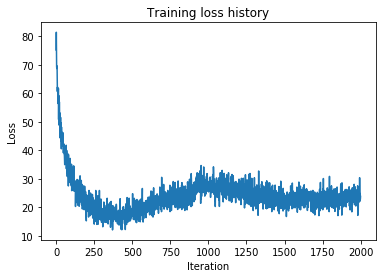

In [15]:
small_data = load_coco_data(max_train=1000)

small_RNN_model = CaptioningRNN(cell_type='RNN',
                              word_to_idx=data['word_to_idx'],
                              input_dim=data['train_features'].shape[1],
                              hidden_dim=512,
                              wordvec_dim=256
                              )
small_RNN_solver = CaptioningSolver(small_RNN_model, small_data,
       update_rule='Adam',
       num_epochs=50,
       batch_size=25,
       optim_config={
         'learning_rate': 5e-3,
       },
       lr_decay=0.95,
       verbose=True, print_every=10,
     )

small_RNN_solver.train()

# Plot the training losses
plt.plot(small_RNN_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

## 4.4 Test-time sampling

Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

In the file `CS231n/classifiers/rnn.py`, implement the sample method for test-time sampling. After doing so, run the following to sample from your overfit model on both training and validation data. The samples on training data should be very good; the samples on validation data probably won't make sense.

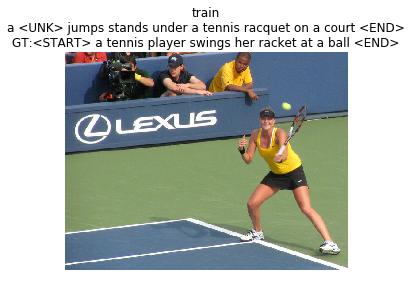

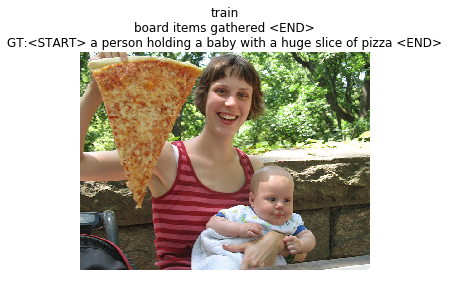

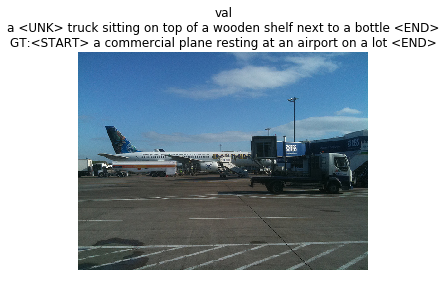

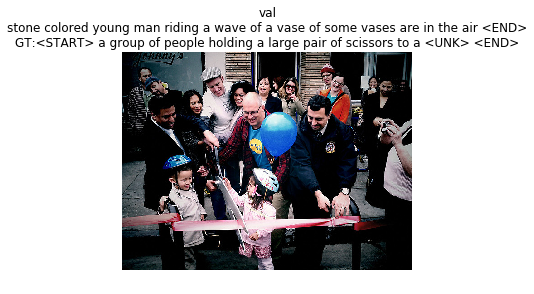

In [16]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_RNN_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        #print url
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()